# Twitter Sentiment Analysis project

# 1 - Import libs

In [1]:
import pandas as pd
import re
import numpy as np
import pickle

# nltk
from nltk.stem import WordNetLemmatizer

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# sklearn
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

Goal : developpin a Sentiment Analysis model to categorize a tweet as Positive or Negative

Ddefinitions : 
>> Sentiment Analysis: The interpretation and classification of emotions (positive, negative and neutral) within text data using text analysis techniques.

# 2 - Get the data

In [2]:
data = pd.read_csv('/Users/civicfab/Desktop/Documents/Ironhack/Final Project/labeled_data.csv')

In [3]:
data = data.drop('Unnamed: 0', axis=1)
data.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


# 3 - Cleaning & Preprocessing

Text processing = transforming text to a more ntelligible form step by step
- lower case
- replacing usernames by user
- replacing urls : "http" or "https" or "www" replaced by "URL"
- removing acronyms : removing "lol" or "xd" or "lmao"... 
- removing non-alphabets : replacing characters except Digits and Alphabets with a space
- removing consecutive letters 
- removing stpwords : English words which does not add much meaning to a sentence
- removing short words : words with length less than 2 are removed
- lematizing : lemmatization is the process of converting a word to its base form

In [4]:
data['sentiment'] = data['class'].apply(lambda x : 0 if x <=1 else 1)

In [5]:
data = data[['tweet', 'sentiment']]

In [6]:
data.head()

,tweet,sentiment
0,!!! RT @mayasolovely: As a woman you shouldn't...,1
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,0
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,0
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,0
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,0


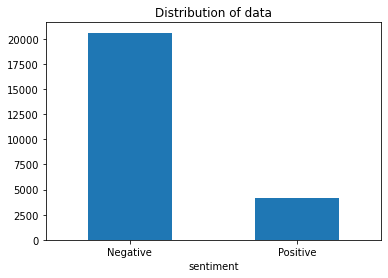

In [7]:
# Plotting the distribution for dataset.
ax = data.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(data['tweet']), list(data['sentiment'])

In [8]:
temp = data.groupby('sentiment').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,tweet
0,0,20620
1,1,4163


Imbalanced data ! 

### Dealing with imbalanced data 

In [9]:
neg_data = data[data['sentiment'] == 0]
pos_data = data[data['sentiment'] == 1]

In [10]:
frames = [neg_data.iloc[:4000], pos_data]
balanced_data = pd.concat(frames)

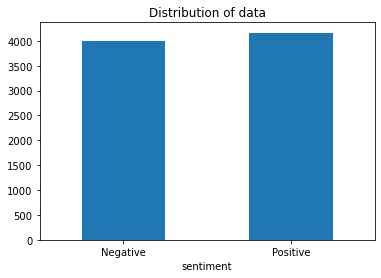

In [11]:
# Plotting the distribution for dataset.
ax = balanced_data.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
balanced_text, balanced_sentiment = list(balanced_data['tweet']), list(balanced_data['sentiment'])

## Words to handle

In [12]:
# Defining dictionary containing all emojis with their meanings.
acronyms = ['lol', 'lmfao', 'rofl', 'xd', 'lmao', 'lolz', 'lqtm', 'haha', 'lmho']


## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves', 'USER', 'URL']

In [13]:
def preprocess(textdata, stopwordlist, acroynms):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        
        tweet = tweet.lower()
        
        # Replace all urls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)      
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword or an acronyms.
            if (word not in stopwordlist) and (word not in acronyms):
                if len(word)>2:
                    # Lemmatizing the word.
                    word = wordLemm.lemmatize(word)
                    tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [14]:
import time
t = time.time()
processedtext = preprocess(text, stopwordlist, acronyms)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 2 seconds


# Analysing the data

Time to analyse the preprocessed data. We'll plot Word Clouds for tweets from our dataset and see which words occur the most

## Word Cloud

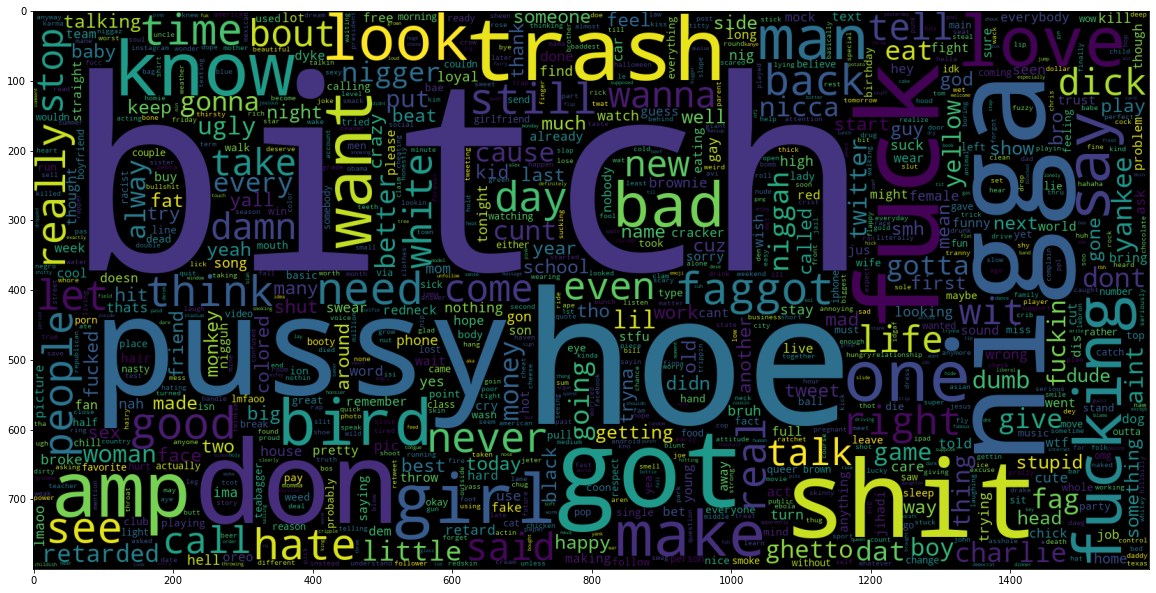

In [15]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(processedtext))
plt.imshow(wc)

Hate speech occurs the most

# Splitting the Data

We split the processed data in two datasets:
- training data : the dataset upon which the model would be trained on. Contains 95% data.
- testing data : the dataset upon which the model would be tested against. Contains 5% data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


## Terme Frequency-Inverse Document Frequency (TF-IDF)

- TF : TF is the frequency with which a given term is used in a text. Calulation method: we divide the number of occurrences of the word concerned in the text by the total number of words in the text.
- F-IDF : TF-IDF is a score that measures the relevance of a word or a key term in an article based on its rarity in a set of pages
- TF-IDF Vectoriser converts a collection of raw documents to a matrix of TF-IDF features. The Vectoriser is usually trained on only the X_train dataset
- ngram_range is the range of number of words in a sequence. 

In [17]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  125881


/Users/civicfab/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## transforming the dataset

In [18]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


### Creating and Evaluating Models

In [19]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## LinearSVC Model

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1043
           1       0.85      0.85      0.85       197

    accuracy                           0.95      1240
   macro avg       0.91      0.91      0.91      1240
weighted avg       0.95      0.95      0.95      1240



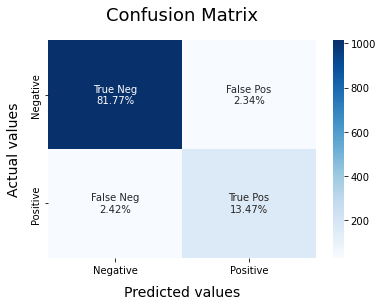

In [20]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

## Logistic Regression Model

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1043
           1       0.89      0.74      0.81       197

    accuracy                           0.94      1240
   macro avg       0.92      0.86      0.89      1240
weighted avg       0.94      0.94      0.94      1240



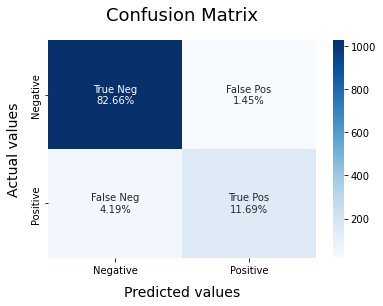

In [21]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [22]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

# Using the model

In [24]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('..path/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('..path/Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text, stopwordlist, acronyms))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["I hate you",
            "I will kill you",
            " I don't feel so good",
            "You are an asshole",
            "I love Donald Trump",
            "I like donuts",
            "I hope you will doing great",
            "Donald Trump spreads fake news"]
    
    df = predict(vectoriser, LRmodel, text)
    print(df.head(10))

                             text sentiment
0                      I hate you  Negative
1                 I will kill you  Negative
2            I don't feel so good  Negative
3              You are an asshole  Negative
4             I love Donald Trump  Negative
5                   I like donuts  Negative
6     I hope you will doing great  Positive
7  Donald Trump spreads fake news  Negative
